In [1]:
from PyTorchLabFlow import *

In [2]:
%%HTML
<style>.container{width:100%}</style>

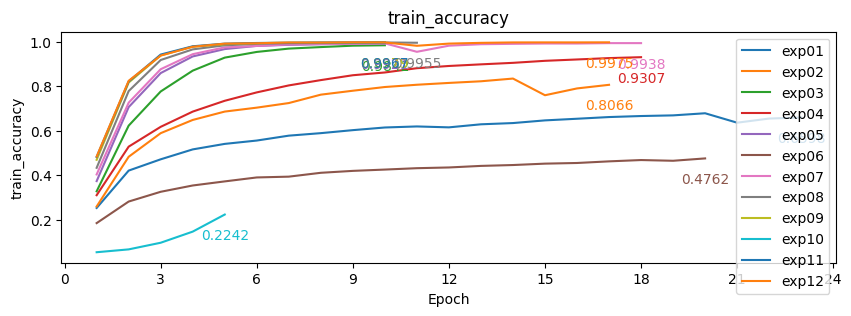

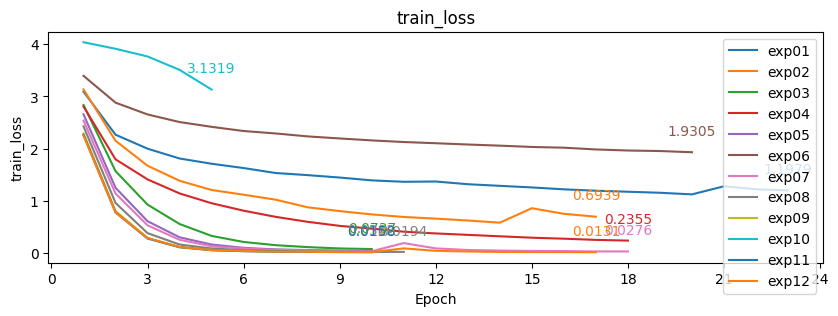

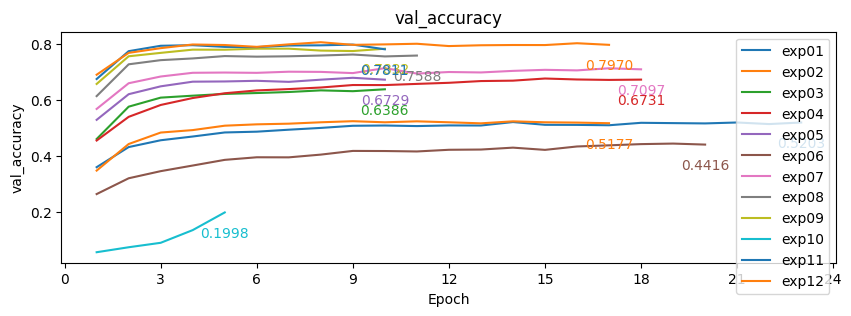

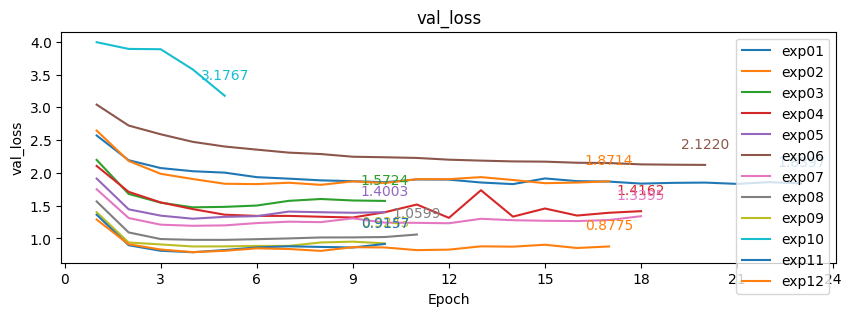

In [3]:
sx = performance_plot(figsize=(10,3))

In [11]:
ppls = get_ppls()
ppl_model = {i:re_train(ppl=i).model_name for i in ppls}
print("_40 == training last 40 layers\n_un== training all layers\n the last exp12 uses dynamic learning rate")
ppl_model

_40 == training last 40 layers
_un== training all layers
 the last exp12 uses dynamic learning rate


{'exp01': 'EffiB3',
 'exp02': 'ResN50',
 'exp03': 'ResN50_10',
 'exp04': 'EffiB3_10',
 'exp05': 'ResN50_15',
 'exp06': 'Vgg19',
 'exp07': 'ResN50_20',
 'exp08': 'ResN50_25',
 'exp09': 'ResN50_35',
 'exp10': 'ResN50_un',
 'exp11': 'ResN50_40',
 'exp12': 'ResN50_40'}

## Best approach 

In [5]:
exp_acc = [[i,j['best_val_accuracy']] for i,j in get_ppls(mode="all").items()]
exp_acc = sorted(exp_acc,key=lambda x:x[1])
exp_acc

[['exp10', 0.1997823383084577],
 ['exp06', 0.4415526535380539],
 ['exp02', 0.5210302653745632],
 ['exp01', 0.5218283582979174],
 ['exp03', 0.6158271144278606],
 ['exp04', 0.6617330016929712],
 ['exp05', 0.6657027364963323],
 ['exp07', 0.697377694928231],
 ['exp08', 0.7569444444938679],
 ['exp09', 0.7798714759708637],
 ['exp11', 0.7958022391618188],
 ['exp12', 0.7982587065566239]]

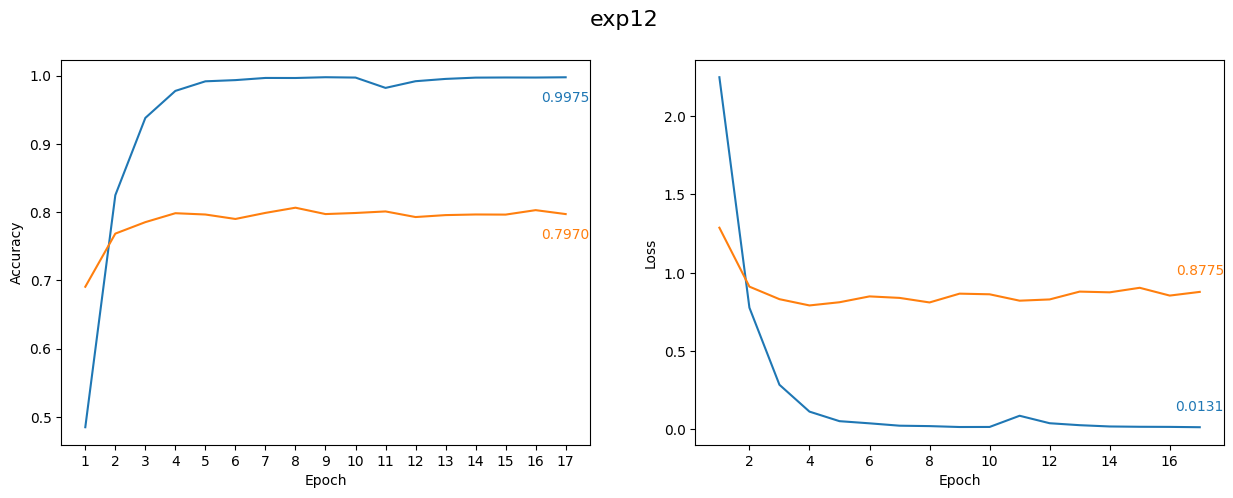

In [6]:
ppl = exp_acc[-1][0]
xs = performance_plot(ppl=ppl)

## exp12

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.optim import Adam
from torchsummary import summary  # Import the summary function
from PyTorchLabFlow import test_mods
class ResN50_40(nn.Module):
    def __init__(self):
        super(ResN50_40, self).__init__()

        self.desc = "[3,224,224] -> ResNet50preTrained(-40:)[2048] -> 256 -> 74"

        # Step 1: Load ResNet50 base model (without pre-trained weights)
        self.base_model = models.resnet50(weights=None)  # No pretrained weights at first
        self.base_model.fc = nn.Identity()  # Remove the final fully connected (fc) layer

        # Step 2: Load the pre-trained weights into the base model
        state_dict = torch.load("preTrained/resnet50_pretrained.pth", weights_only=True)
        self.base_model.load_state_dict(state_dict, strict=False)  # Load the pre-trained weights

        # Custom layers after the base model
        self.fc1 = nn.Linear(2048, 256)  # Fully connected layer
        self.batch_norm = nn.BatchNorm1d(256)  # Apply BatchNorm after fc1
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 74)  # Output layer (num_classes will be 74)

        # Step 3: Create a list of all parameters
        self.params = list(self.base_model.named_parameters())
        # print(f"Total parameters: {len(self.params)}")

        # Identify the last 10 layers
        self.last_40_params = self.params[-40:]  # Get the last 10 parameters

        # Step 4: Freeze all layers except the last 10 layers
        for name, param in self.base_model.named_parameters():
            param.requires_grad = False  # Freeze all layers initially

        # Step 5: Unfreeze the last 10 layers
        for name, param in self.last_40_params:
            param.requires_grad = True  # Unfreeze the last 10 layers

    def forward(self, x):
        # Forward pass through ResNet50 base model
        x = self.base_model(x)  # Get features from ResNet50
        x = self.fc1(x)          # Apply fully connected layer 1
        x = self.batch_norm(x)   # Apply batch normalization after fc1
        x = self.relu(x)         # ReLU activation
        x = self.dropout(x)      # Apply dropout
        x = self.fc2(x)          # Output layer
        return x

# Initialize the model
model = ResN50_40()

# Assuming 'device' is the variable where the device is specified, e.g., 'cuda' or 'cpu'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device (GPU if available, otherwise CPU)
model = model.to(device)

# Display model summary
summary(model, input_size=(3, 224, 224))  # Input size (C, H, W) for ResNet50


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Dataset 

In [8]:
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch

class DS_01(Dataset):
    def __init__(self, root_dir):
        self.desc = "resize[224, 224] -> transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])"
        self.root_dir = root_dir
        
        # Define default transformations (resize, to tensor, and normalization)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224 pixels
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
        ])
        
        # Get all class names (subfolder names)
        self.class_names = sorted(os.listdir(root_dir))
        
        # Create a mapping from class name to class index
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        
        # Collect all image paths and their corresponding class labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for filename in os.listdir(class_dir):
                    if filename.endswith(('.png', '.jpg', '.jpeg')):  # You can adjust extensions
                        self.image_paths.append(os.path.join(class_dir, filename))
                        self.labels.append(self.class_to_idx[class_name])
    def collate_fn(batch):
        inputs, labels = zip(*batch)  # Unzip the batch into inputs and labels
        inputs = torch.stack(inputs, dim=0)  # Stack inputs to create a tensor
        labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor of type long (integer)
        def one_hot_encode(labels, num_classes=74):
            # Convert integer labels to one-hot encoded labels
            return torch.eye(num_classes)[labels]
        # Apply one-hot encoding to the labels
        labels = one_hot_encode(labels)
        
        return inputs, labels
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")  # Convert to RGB to ensure consistent color channels
        
        # Get the label for the image
        label = self.labels[idx]
        
        # Apply transformations if provided
        img = self.transform(img)
        
        return img, label


## Optimizer


In [9]:
class OptimizerWithScheduler:
   def __init__(self, optimizer, scheduler_type='StepLR', **kwargs):
            # Create Adamax optimizer
            self.optimizer = optimizer
            
            # Choose the scheduler
            if scheduler_type == 'StepLR':
                self.scheduler = StepLR(self.optimizer, step_size=5, gamma=0.1)
            elif scheduler_type == 'ReduceLROnPlateau':
                self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=3)
            else:
                raise ValueError(f"Unknown scheduler type: {scheduler_type}")

   def step(self, loss=None):
            """ Perform one step of optimization and adjust the learning rate using the scheduler. """
            self.optimizer.step()

            # If using ReduceLROnPlateau, pass the loss to adjust the learning rate
            if isinstance(self.scheduler, ReduceLROnPlateau) and loss is not None:
                self.scheduler.step(loss)  # This adjusts the LR based on validation loss
            elif isinstance(self.scheduler, StepLR):
                self.scheduler.step()  # This just steps based on epochs, so no need for loss

   def zero_grad(self):
            """ Zero out the gradients in the optimizer """
            self.optimizer.zero_grad()

   def get_lr(self):
            """ Get the current learning rate """
            return self.optimizer.param_groups[0]['lr']  # Assuming a single learning rate for all params
   def get_last_lr(self):
            """ Get the last learning rate from the scheduler """
            return self.scheduler.get_last_lr()[0] 
    

def OptAdamax_sc(model, **kwargs):
   optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-5)
    # Create and return an instance of the OptimizerWithScheduler class
   return OptimizerWithScheduler(optimizer, "ReduceLROnPlateau", **kwargs)

## Accuracy & Loss

In [10]:
def CrossEn():
    return nn.CrossEntropyLoss()

class MultiAcc(torch.nn.Module):
    def __init__(self):
        super(MultiAcc, self).__init__()

    def forward(self, output, target):
        # Predicted class is the index with the highest logit
        _, predicted = torch.max(output, 1)  # Predicted class indices (shape: [batch_size])

        # If target is one-hot encoded, we need to extract the indices
        if target.dim() > 1:  # If target is one-hot encoded (shape: [batch_size, num_classes])
            target = torch.argmax(target, dim=1)  # Convert to class indices (shape: [batch_size])

        # Compare predicted vs true labels and calculate accuracy
        correct = (predicted == target).float()  # Correct predictions (shape: [batch_size])
        accuracy = correct.sum() / target.size(0)  # Mean accuracy across the batch
        return accuracy